# The Wannier-projected density of states, populations and charges

In [1]:
%config InlineBackend.figure_format = 'retina'

![The structure of rutile with a single Wannier function plotted](images/structure.png)

As well as enabling the calculation of bonding descriptors from Wannier functions, `pengwann` also allows for the computation of a Wannier-projected density of states which can be integrated to derive atomic populations and charges.

## The Wannier-projected density of states

In [2]:
from pengwann.geometry import build_geometry

geometry = build_geometry(seedname='wannier90', path='inputs')

print(geometry)

Full Formula (X28 Ti2 O4)
Reduced Formula: X14TiO2
abc   :   4.587891   4.587891   2.938132
angles:  90.000000  90.000000  90.000000
pbc   :       True       True       True
Sites (34)
  #  SP            a          b          c  wannier_centres
---  ----  ---------  ---------  ---------  --------------------
  0  X0+    0.5        0.5       -2.6e-05   (28,)
  1  X0+    0.5        0.5        0         (28,)
  2  X0+    0.5        0.5        9e-06     (28,)
  3  X0+    0.5        0.5        9e-06     (28,)
  4  X0+    0.5        0.5        5.5e-05   (28,)
  5  X0+    0.5        0.5       -1.4e-05   (28,)
  6  X0+   -0         -0          0.500026  (29,)
  7  X0+   -0         -0          0.5       (29,)
  8  X0+    0          0          0.499991  (29,)
  9  X0+    0          0          0.499991  (29,)
 10  X0+    0          0          0.499945  (29,)
 11  X0+    0          0          0.500014  (29,)
 12  X0+    0.644645   0.644645   0.508848  (30,)
 13  X0+    0.717603   0.717603   0.5993

In previous [examples](../../examples), we have used the {py:func}`~pengwann.geometry.identify_interatomic_interactions` function to find bonds and describe them in terms of the interacting atoms' assigned Wannier functions. To instead calculate local atomic properties such as the Wannier pDOS, we make use of the {py:func}`~pengwann.geometry.identify_onsite_interactions` function:

In [3]:
from pengwann.geometry import identify_onsite_interactions

# The atomic species for which to obtain interactions.
symbols = ('Ti', 'O')

interactions = identify_onsite_interactions(geometry, symbols)

print(interactions)

Atomic interactions
Ti28 <=> Ti28
Ti29 <=> Ti29
O30 <=> O30
O31 <=> O31
O32 <=> O32
O33 <=> O33



The meaning of "on-site" interactions in this context is made slightly clearer if we examine a specific {py:class}`~pengwann.interactions.AtomicInteraction`:

In [4]:
print(interactions[28, 28])

Atomic interaction Ti28 <=> Ti28
DOS matrix => Not calculated
WOHP => Not calculated
WOBI => Not calculated
IWOHP => Not calculated
IWOBI => Not calculated
Population => Not calculated
Charge => Not calculated


Associated Wannier interactions
-------------------------------
0[0, 0, 0] <=> 0[0, 0, 0]
1[0, 0, 0] <=> 1[0, 0, 0]
2[0, 0, 0] <=> 2[0, 0, 0]
3[0, 0, 0] <=> 3[0, 0, 0]
4[0, 0, 0] <=> 4[0, 0, 0]
5[0, 0, 0] <=> 5[0, 0, 0]



As seen above, an on-site interaction in `pengwann` refers to all of the diagonal terms, in which the coefficients used to calculate the DOS matrix are related by complex conjugation, yielding the Wannier-projected density of states:

$$\mathrm{pDOS}_{\alpha}(E) = \sum_{nk}\mathrm{Re}\left[\left(C^{\alpha}_{nk}\right)^{*}C^{\alpha}_{nk}\right]\cdot\delta(E - \epsilon_{nk}).$$

:::{note}
For more details regarding the mathematical formalism employed in `pengwann`, please see the [methodology](../../methodology) page and the [API reference](../../api).
:::

In [5]:
from pengwann.descriptors import DescriptorCalculator
from pengwann.io import read
from pengwann.occupations import get_occupation_matrix

kpoints, eigenvalues, u_matrices, _ = read(seedname='wannier90',
                                           path='inputs')

mu = 9.5
nspin = 2

num_wann = 28
energy_range = (-20, 20)
resolution = 0.1
sigma = 0.1

dcalc = DescriptorCalculator.from_eigenvalues(eigenvalues,
                                              num_wann,
                                              nspin,
                                              energy_range,
                                              resolution,
                                              sigma,
                                              kpoints,
                                              u_matrices)

Having initialised a {py:class}`~pengwann.descriptors.DescriptorCalculator` in much the same way as we would to calculate bonding descriptors, we can now obtain the pDOS by calling the {py:meth}`~pengwann.descriptors.DescriptorCalculator.assign_descriptors` method on our on-site `interactions`:

In [6]:
interactions = dcalc.assign_descriptors(interactions,
                                        calc_wohp=False,
                                        calc_wobi=False)

  0%|          | 0/28 [00:00<?, ?it/s]

Note that, as we are only interested in the DOS matrix in this case, we have set the `calc_wohp` and `calc_wobi` keyword arguments to `False` to avoid unnecessarily fetching or computing elements of the Wannier Hamiltonian and Wannier density matrix.

We can now plot the pDOS for a given atom simply by accessing the `dos_matrix` attribute. For example, for `Ti28`:

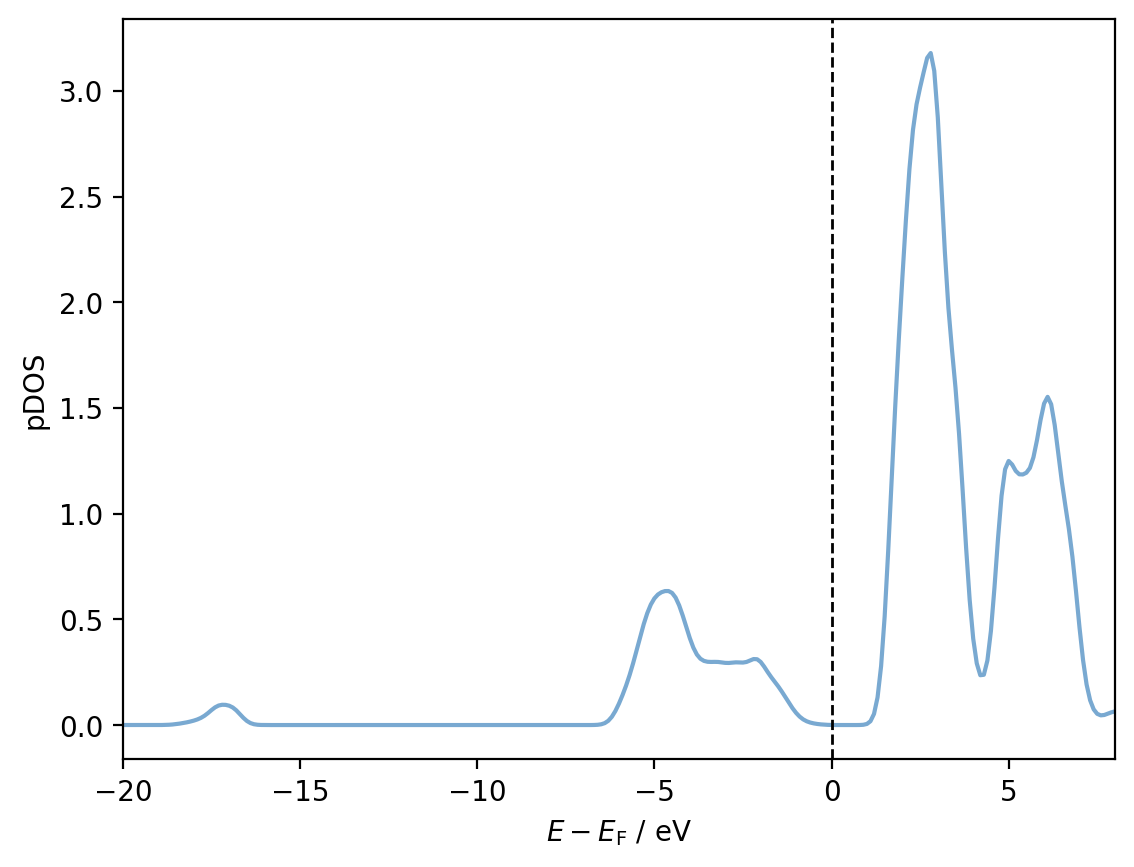

In [7]:
import matplotlib.pyplot as plt

# Colours for plots
ti_colour = '#79a9d1'
o_colour = '#ff4365'

shifted_energies = dcalc.energies - mu

fig, ax = plt.subplots()

pdos = interactions[28, 28].dos_matrix
ax.plot(shifted_energies, pdos, color=ti_colour)
ax.axvline(x=0, color='black', ls='--', lw=1)

ax.set_xlim(-20, 8)

ax.set_xlabel(r'$E - E_{\mathrm{F}}$ / eV')
ax.set_ylabel('pDOS')

plt.show()

:::{note}
In much the same way that bonding descriptors such as the Wannier orbital Hamilton population (WOHP) can be resolved with respect to individual Wannier functions (see this [example](../diamond/orbital_and_k_resolution)), the same is true of the pDOS.
:::

To plot the pDOS in terms of atomic species rather than individual atoms, we simply sum over atoms of the same species. Accessing all interactions involving a certain subset of atomic species/elemental symbols is easily accomplished using the {py:meth}`~pengwann.interactions.AtomicInteractionContainer.filter_by_species` method:

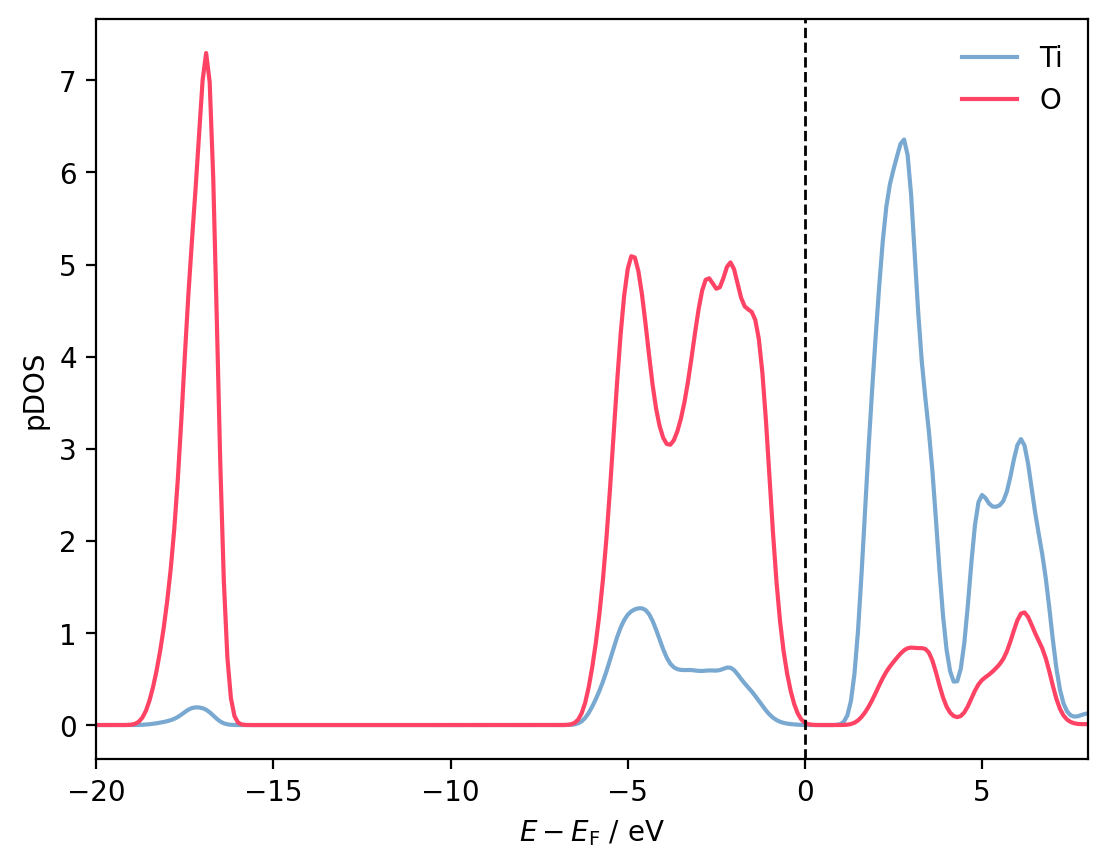

In [8]:
ti_pdos = sum(
    interaction.dos_matrix for interaction in 
    interactions.filter_by_species(['Ti'])
)
o_pdos = sum(
    interaction.dos_matrix for interaction in 
    interactions.filter_by_species(['O'])
)

fig, ax = plt.subplots()

ax.plot(shifted_energies, ti_pdos, color=ti_colour, label='Ti')
ax.plot(shifted_energies, o_pdos, color=o_colour, label='O')
ax.axvline(x=0, color='black', ls='--', lw=1)

ax.set_xlim(-20, 8)

ax.set_xlabel(r'$E - E_{\mathrm{F}}$ / eV')
ax.set_ylabel('pDOS')

ax.legend(frameon=False)

plt.show()

## Populations and charges

The pDOS can be integrated to derive a Löwdin-style population for a particular Wannier function or atom.

In [9]:
interactions = interactions.with_integrals(dcalc.energies, mu)

for interaction in interactions:
    print(f'Population for {interaction.tag} = {interaction.population:.2f}')

Population for Ti28 <=> Ti28 = 1.87
Population for Ti29 <=> Ti29 = 1.87
Population for O30 <=> O30 = 7.06
Population for O31 <=> O31 = 7.06
Population for O32 <=> O32 = 7.06
Population for O33 <=> O33 = 7.06


If we also provide `valence_counts` to the {py:meth}`~pengwann.interactions.AtomicInteractionContainer.with_integrals` method, then we will also have access to charges for each atom too:

In [10]:
valence_counts = {'Ti': 4, 'O': 6}

interactions = interactions.with_integrals(dcalc.energies,
                                           mu,
                                           valence_counts=valence_counts)

for interaction in interactions:
    print(f'Charge for {interaction.tag} = {interaction.charge:.2f}')

Charge for Ti28 <=> Ti28 = 2.13
Charge for Ti29 <=> Ti29 = 2.13
Charge for O30 <=> O30 = -1.06
Charge for O31 <=> O31 = -1.06
Charge for O32 <=> O32 = -1.06
Charge for O33 <=> O33 = -1.06


The relationship between populations and charges in this instance is trivial, the charge is simply the difference between the number of valence electrons associated with an atom (according to the pseudopotential used in the ab initio calculation) and its population.